<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/11a_jax.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(jax-notebook)=
# Usare JAX per un campionamento più veloce

In precedenza, abbiamo utilizzato il campionatore predefinito fornito da PyMC. Tuttavia, esiste un'alternativa più efficiente che utilizza l'algoritmo NUTS (No-U-Turn Sampler) implementato con la libreria JAX. Questo campionatore è noto per la sua capacità di eseguire il campionamento in modo più veloce e efficiente. Per utilizzare questa opzione, è possibile seguire la procedura descritta in questo capitolo.

Prima di procedere, è necessario installare JAX e le librerie associate. Poiché NumPyro è una libreria che dipende da JAX, si può installare con il seguente comando Conda nell'ambiente virtuale dove abbiamo installato PyMC:

```bash
conda install -c conda-forge jax
conda install -c conda-forge numpyro
```

Dopo aver completato l'installazione, è possibile importare il modulo per il campionamento basato su JAX:

```python
import pymc.sampling_jax
```

Con questi passaggi, è possibile utilizzare il campionatore basato su JAX per effettuare analisi più rapide ed efficienti.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Per fare un esempio pratico, consideriamo nuovamente i dati relativi agli artisti della Generazione X nel MOMA. Ricordiamo che i dati corrispondono a 14 successi su 100 prove. Come in precedenza, imposteremo sul parametro $\theta$ (probabilità di appartenere alla Generazione X o successive) una distribuzione Beta(4, 6). Il modello, dunque, si presenta come:

$$
\begin{align}
y &\sim Bin(n, \theta) \notag\\
\theta &\sim Beta(4, 6)
\end{align}
$$ 

In [3]:
# Dati
y = 14
ntrials = 100

In [4]:
# Distribuzione a priori
alpha_prior = 4
beta_prior = 6

## Definire il modello

Il modello PyMC viene specificato esattamente come abbiamo fatto in precedenza.

In [5]:
model = pm.Model()

with model:
    # Prior
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    # Likelihood
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

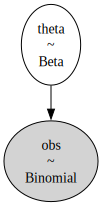

In [6]:
pm.model_to_graphviz(model)

## Esecuzione del campionamento

In precedenza, per il campionamento abbiamo usato la funzione `pm.sample()`.

In [8]:
with model:
    idata1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Sul mio computer questo richiede circa 27 s.

Ripetiamo ora il campionamento, facendo ricorso al campionatore JAX. Per quel che riguarda il codice, useremo l'istruzione `pm.sampling_jax.sample_numpyro_nuts()`.

In [9]:
with model:
    idata2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.439415
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1756.44it/s]
Sampling time = 0:00:01.701952
Transforming variables...
Transformation time = 0:00:00.063867


Si osservi che, nel caso in esame, il processo di campionamento ha impiegato solamente 2 secondi. Sebbene questa accelerazione possa sembrare trascurabile per modelli di semplice costruzione, assume un'importanza significativa quando si tratta di modelli più complessi. In scenari in cui il campionamento può richiedere ore di elaborazione, una diminuzione anche solo del 50% del tempo necessario può avere un impatto considerevole dal punto di vista pratico.

Una volta ottenuto l'oggetto `idata`, questo può essere manipolato come abbiamo fatto in precedenza. Per esempio, per produrre la traccia e la distribuzione a posteriori di $\theta$ chiamiamo `az.plot_trace()`.

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

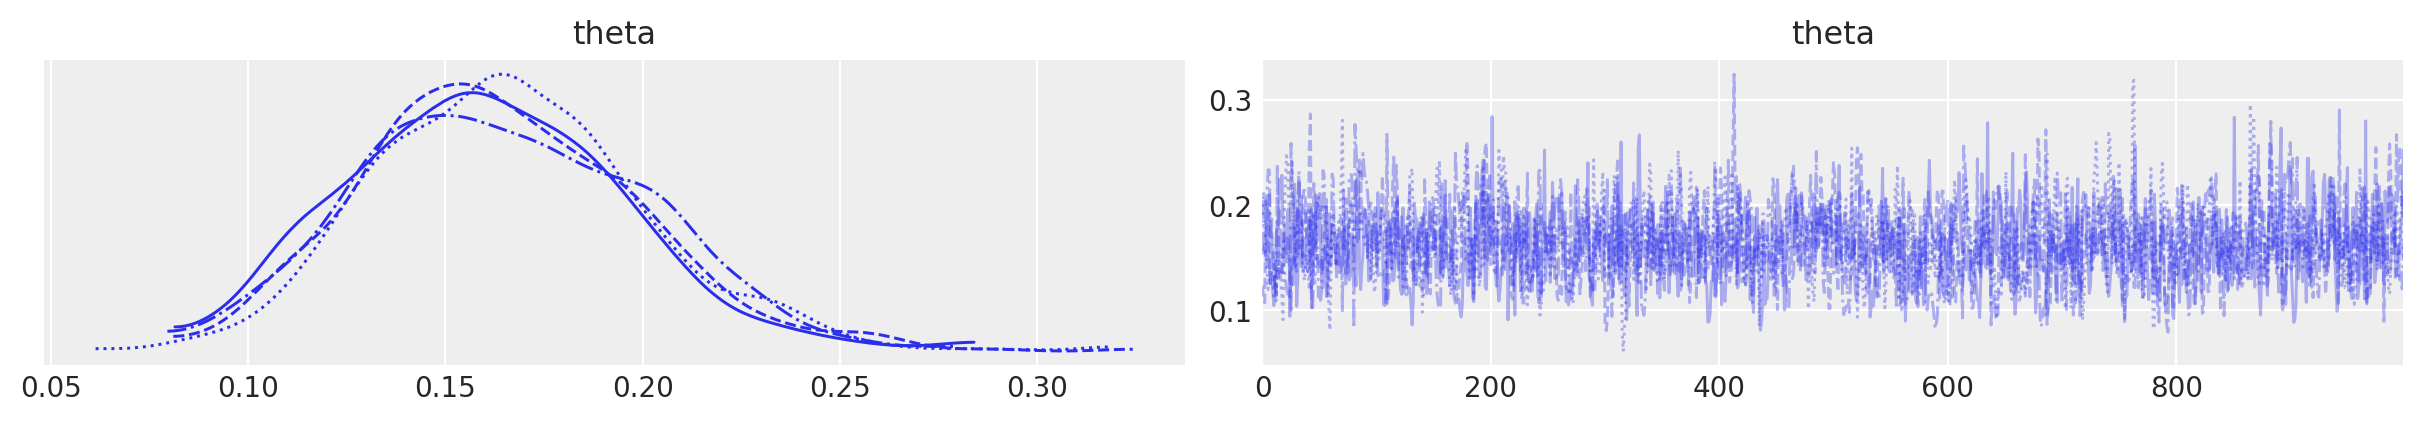

In [10]:
az.plot_trace(idata2)

Per un sommario della distribuzione a posteriori usiamo `az.summary()`.

In [11]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.102,0.229,0.001,0.001,1370.0,1714.0,1.0


## Commenti e considerazioni finali 

L'implementazione di JAX in PyMC segna un avanzamento notevole nel processo di campionamento, offrendo una soluzione più veloce ed efficiente rispetto ai metodi tradizionali. La capacità di JAX di accelerare le operazioni di campionamento permette una maggiore agilità nell'analisi, riducendo i tempi di attesa e facilitando l'esplorazione di modelli più complessi. Inoltre, la sua integrazione semplice e senza soluzione di continuità con PyMC rende accessibili questi vantaggi senza richiedere modifiche al codice esistente. 

## Watermark

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p numpyro

Last updated: Thu Dec 28 2023

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpyro: 0.13.2

arviz     : 0.17.0
scipy     : 1.11.4
pymc      : 5.10.3
matplotlib: 3.8.2
numpy     : 1.26.2

Watermark: 2.4.3

